In [209]:
import seaborn as sns
from itertools import chain
import pandas as pd
import seaborn as sns
from shapely.geometry import Point, MultiPoint
import geopandas as gpd
from feature_geometries import *


from bs4 import BeautifulSoup
import requests

In [168]:
req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
}

def url_rent(page):
    return 'https://www.zillow.com/homes/for_rent/Oakland-CA/all_type/13072_rid/37.971537,-121.981545,37.612327,-122.47593_rect/10_zm/' + page + '_p/'


In [180]:
all_addresses = []
all_characteristics = []
all_prices = []
all_lats = []
all_longs = []

for page in np.arange(1, 21):
    with requests.Session() as s:
        url = url_rent(str(page))
        r = s.get(url, headers=req_headers)
        
        soup = BeautifulSoup(r.content, 'lxml')
        
        address = soup.find_all('span', {'itemprop': 'address'})
        characteristics = soup.find_all('span', {'class': 'zsg-photo-card-info'})
        price = soup.find_all('span', {'class': 'zsg-photo-card-price'})
        
        address_list = [value.text for value in address]
        char_list = [value.text for value in characteristics]
        price_list = [value.text for value in price]
        lat_list = [item['content'] for item in soup('meta') 
               if item.has_attr('itemprop') and item.attrs['itemprop']  == 'latitude']
        long_list = [item['content'] for item in soup('meta') 
               if item.has_attr('itemprop') and item.attrs['itemprop']  == 'longitude']
        
        # add to master list
        all_addresses.append(address_list)
        all_characteristics.append(char_list)
        all_prices.append(price_list)
        all_lats.append(lat_list)
        all_longs.append(long_list)



In [181]:
from itertools import chain
import pandas as pd

#clean the characteristics columns for erroneous price data
characteristics = list(chain.from_iterable(all_characteristics))
characteristics = [value for value in characteristics if not ('$' in value)]

Oakland_rentals = pd.DataFrame(
    {'address': list(chain.from_iterable(all_addresses)),
     'latitude': list(chain.from_iterable(all_lats)),
     'longitude': list(chain.from_iterable(all_longs)),
     'price': list(chain.from_iterable(all_prices)),
     'characteristics': characteristics 
    })

Oakland_rentals[['beds', 'baths', 'sqft']] = Oakland_rentals['characteristics'].str.split('·\s+', expand=True)
Oakland_rentals = Oakland_rentals.drop('characteristics', axis=1)

#clean up the columns...
Oakland_rentals['price'] = Oakland_rentals.price.str.strip('$/mo')
Oakland_rentals['price'] = Oakland_rentals.price.str.replace(',', '')
Oakland_rentals['price'] = Oakland_rentals.price.str.replace('+', '').astype(int)

Oakland_rentals['sqft'] = Oakland_rentals.sqft.str.replace('sqft', '')
Oakland_rentals['sqft'] = Oakland_rentals.sqft.str.replace('--', '0')
Oakland_rentals['sqft'] = Oakland_rentals.sqft.str.replace(',', '').astype(int)
Oakland_rentals['sqft'] = Oakland_rentals.sqft.replace(0, np.nan)

Oakland_rentals['latitude'] = Oakland_rentals.latitude.astype(float)
Oakland_rentals['longitude'] = Oakland_rentals.longitude.astype(float)

Oakland_rentals.head(3)

,address,latitude,longitude,price,beds,baths,sqft
0,2450 Palmetto St OAKLAND CA 94602,37.799085,-122.213724,2350,1 bd,1 ba,620.0
1,1018 28th St # 1018 Oakland CA 94608,37.819857,-122.279444,3300,4 bds,1 ba,1500.0
2,Oak Knoll Blvd OAKLAND CA 94605,37.756230,-122.151250,3400,2 bds,1 ba,1092.0


In [182]:
geometry = [Point(xy) for xy in zip(Oakland_rentals.longitude, Oakland_rentals.latitude)]
Oakland_rentals = gpd.GeoDataFrame(Oakland_rentals, geometry=geometry, crs={'init' :'epsg:4326'}) #Mercator lat long input

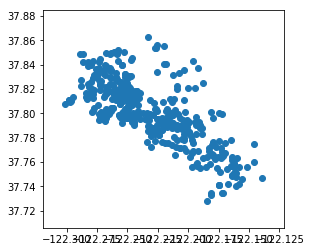

In [185]:
Oakland_rentals.plot();

In [288]:
neighborhoods = gpd.read_file("data/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp")
oakland_neighborhoods = neighborhoods[neighborhoods.City == "Oakland"]
oakland_neighborhoods.head()

,State,County,City,Name,RegionID,geometry
24,CA,Alameda,Oakland,Chinatown,114292,POLYGON ((-122.2700929749999 37.80135293100005...
273,CA,Alameda,Oakland,Adams Point,267990,POLYGON ((-122.2493849479999 37.81247701900008...
283,CA,Alameda,Oakland,Civic Center,268073,POLYGON ((-122.2629218196665 37.80108023766672...
291,CA,Alameda,Oakland,East Peralta,268125,POLYGON ((-122.2513529469999 37.79354501800009...
294,CA,Alameda,Oakland,Elmhurst Park,268142,POLYGON ((-122.1710949479999 37.74504101800005...


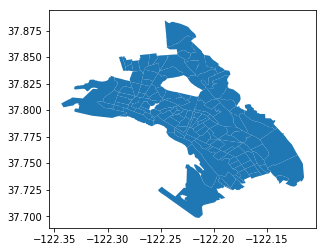

In [283]:
oakland_neighborhoods.plot()

In [304]:
rentals_by_zone = gpd.sjoin(Oakland_rentals, oakland_neighborhoods, how='left', op='intersects')

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


/anaconda3/envs/OSMNX/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


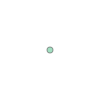

In [317]:
rentals_by_zone.ix[3, 'geometry']

In [307]:
neighborhoods = rentals_by_zone.groupby('Name').mean()
neighborhoods.drop(['index_right'], inplace = True, axis=1)
neighborhoods.reset_index(inplace = True)
neighborhoods.head()

,Name,latitude,longitude,price,sqft
0,Adams Point,37.812744,-122.254746,2868.555556,1197.25
1,Allendale,37.787097,-122.204082,2537.166667,733.00
2,Arroyo Viejo,37.761561,-122.178430,2148.333333,892.50
3,Bartlett,37.789724,-122.209121,3287.000000,1425.00
4,Bella Vista,37.800776,-122.237120,4950.000000,2400.00


In [309]:
#import heatmap data to get average exposures by neighborhood
heatmap = import_gpd('data/app/heatmap.csv')
pollution_by_zone = gpd.sjoin(heatmap, oakland_neighborhoods, how='inner', op='intersects')

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [311]:
pollution = pollution_by_zone.groupby('Name')['no2', 'bc'].mean()
pollution.reset_index(inplace = True)
pollution.head()

,Name,no2,bc
0,Acorn,15.541501,0.516278
1,Acorn Industrial,22.539082,0.873373
2,Adams Point,13.443590,0.429612
3,Allendale,9.813637,0.321972
4,Arrowhead Marsh,13.532892,0.659737


In [312]:
all_data = neighborhoods.merge(pollution, on='Name')
all_data = oakland_neighborhoods.merge(all_data, on='Name')

In [361]:
all_data.to_csv('neighborhood_summaries.csv')
#sns.scatterplot(oakland_neighborhoods.price, oakland_neighborhoods.bc)

In [263]:
adams = 2868
no2_value = 13.44358

In [409]:
def find_nearby_neighborhoods(location, neighborhoods, buffer_dist = 0.015):

    neighborhood_index = neighborhoods.sindex
    circle = location.buffer(buffer_dist) #build a km buffer around location
    
    possible_matches_index = list(neighborhood_index.intersection(circle.bounds)) #get index of possible neighborhoods
    possible_matches = neighborhoods.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(circle)].copy()

    return precise_matches


def get_healthy_suggestions(location, neighborhoods, price_range = 0.2, buffer_dist = 0.015):
    
    #find your current neighborhood...
    current_hood = neighborhoods[neighborhoods.intersects(location)]
    
    #find all neighborhoods within a mile (0.015 deg buffer)
    nearby_hoods = find_nearby_neighborhoods(location, neighborhoods)
    
    #subset neighborhoods in similar price bracket (default is +/- 20%)
    upper = 1 + price_range
    lower = 1 - price_range
    similar_hoods = nearby_hoods[nearby_hoods.price.between(current_hood['price'].iloc[0]*lower, 
                                                            current_hood['price'].iloc[0]*upper)]
    
    
    #find which neighborhoods have lower exposures 
    healthy_hoods = similar_hoods[similar_hoods.no2 < current_hood['no2'].iloc[0]]
    
    #how much lower are the exposure rates?
    healthy_hoods['percent_diff'] = (1 - (healthy_hoods['no2']/current_hood['no2'].iloc[0]))*100
    healthy_hoods['percent_diff'] = healthy_hoods['percent_diff'].astype(int)
    
    return healthy_hoods

In [410]:
out = get_healthy_suggestions(rentals_by_zone.ix[3, 'geometry'], all_data)

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/anaconda3/envs/OSMNX/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [411]:
def create_suggestions(healthy_hoods):
	hoods_statement = str('The following neighborhoods are healthier choices within your budget: ' + str(healthy_hoods.sort_values(by = 'no2')['Name'].values))
	values_statement = str('.  These neighborhoods have ' + str(healthy_hoods.sort_values(by = 'no2')['percent_diff'].values) + 
		' percent lower exposure rates.')
	
	return(hoods_statement +  values_statement)
    #'\nThese neighborhoods have' + healthy_hoods.sort_values(by = 'no2')['percent_diff'].values + 'lower exposure rates'


In [412]:
create_suggestions(out)

"The following neighborhoods are healthier choices within your budget: ['Piedmont Avenue' 'Oakland Ave-Harrison St' 'Ralph Bunche'].  These neighborhoods have [34.03739638  8.29875833  1.93933104] percent lower exposure rates."

In [355]:
test = test[test.no2 < value['no2'].iloc[0]]

In [360]:
print(test.sort_values(by = 'no2')['Name'].values)

['Piedmont Avenue' 'Oakland Ave-Harrison St' 'Ralph Bunche']


In [277]:
oakland_neighborhoods

,State_x,County_x,City_x,Name,RegionID_x,geometry_x,no2,bc,State_y,County_y,City_y,RegionID_y,geometry_y
0,CA,Alameda,Oakland,Chinatown,114292,POLYGON ((-122.2700929749999 37.80135293100005...,15.547257,0.527182,CA,Alameda,Oakland,114292,POLYGON ((-122.2700929749999 37.80135293100005...
1,CA,San Francisco,San Francisco,Chinatown,114291,POLYGON ((-122.4038513287999 37.78983157800024...,15.547257,0.527182,CA,Alameda,Oakland,114292,POLYGON ((-122.2700929749999 37.80135293100005...
2,CA,Los Angeles,Los Angeles,Chinatown,276257,POLYGON ((-118.2376746494332 34.05526664918618...,15.547257,0.527182,CA,Alameda,Oakland,114292,POLYGON ((-122.2700929749999 37.80135293100005...
3,CA,Los Angeles,Los Angeles,Highland Park,115609,"POLYGON ((-118.168053 34.12392300000005, -118....",12.859844,0.450464,CA,Alameda,Oakland,417222,POLYGON ((-122.2293520639999 37.79889008600009...
4,CA,Alameda,Oakland,Highland Park,417222,POLYGON ((-122.2293520639999 37.79889008600009...,12.859844,0.450464,CA,Alameda,Oakland,417222,POLYGON ((-122.2293520639999 37.79889008600009...
5,CA,Contra Costa,Richmond,Santa Fe,237504,"POLYGON ((-122.360034624 37.93125438900006, -1...",11.312132,0.332406,CA,Alameda,Oakland,268456,POLYGON ((-122.2765799999999 37.84652600000004...
6,CA,Alameda,Oakland,Santa Fe,268456,POLYGON ((-122.2765799999999 37.84652600000004...,11.312132,0.332406,CA,Alameda,Oakland,268456,POLYGON ((-122.2765799999999 37.84652600000004...
7,CA,Alameda,Oakland,Adams Point,267990,POLYGON ((-122.2493849479999 37.81247701900008...,13.443590,0.429612,CA,Alameda,Oakland,267990,POLYGON ((-122.2493849479999 37.81247701900008...
8,CA,Alameda,Oakland,Civic Center,268073,POLYGON ((-122.2629218196665 37.80108023766672...,15.425390,0.546467,CA,Alameda,Oakland,268073,POLYGON ((-122.2629218196665 37.80108023766672...
9,CA,Marin,San Rafael,Civic Center,764138,"POLYGON ((-122.53821622 38.00061206700008, -12...",15.425390,0.546467,CA,Alameda,Oakland,268073,POLYGON ((-122.2629218196665 37.80108023766672...
